[Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/abs/1506.02142)

Monte Carlo Dropout on classification of MedMNIST.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import medmnist
from medmnist import INFO, Evaluator
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import numpy as np

data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([transforms.ToTensor()])
train_set = DataClass(split='train', transform=transform, download=download)
test_set = DataClass(split='test', transform=transform, download=download)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


Using downloaded and verified file: /Users/chen/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/chen/.medmnist/pathmnist.npz


In [2]:
class MC_Dropout_CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(MC_Dropout_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [3]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device).squeeze()

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), 100 * correct / total


In [4]:
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

model = MC_Dropout_CNN(num_classes=n_classes, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
num_epochs = 3

for epoch in trange(1, num_epochs + 1):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = test(model, test_loader, criterion, device)
    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 1.1598, Test Loss: 0.8862, Accuracy: 74.6797


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.8980, Test Loss: 0.8358, Accuracy: 75.5153


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.8082, Test Loss: 0.8198, Accuracy: 80.4735


In [9]:
def mc_dropout_prediction(model, dataloader, device, num_samples=100):
    model.train()  # Keep model in train mode to use dropout during inference
    preds = []
    targets = []
    uncertainty = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).squeeze()
            output_list = []

            for _ in range(num_samples):
                outputs = model(images)
                output_list.append(outputs.cpu().numpy())

            mean_output = np.mean(output_list, axis=0)
            std_output = np.std(output_list, axis=0)
            preds.extend(mean_output)
            targets.extend(labels.cpu().numpy())
            uncertainty.extend(std_output)
    
    preds = np.array(preds)
    targets = np.array(targets)
    uncertainty = np.array(uncertainty)

    return preds, targets, uncertainty

preds, targets, uncertainty = mc_dropout_prediction(model, test_loader, device, num_samples=100)


In [10]:
mc_accuracy = np.mean(np.argmax(preds, axis=1) == targets)
print(f"Monte Carlo dropout accuracy: {mc_accuracy:.4f}")
print(f"Uncertainty example: {uncertainty[:10]}")


Monte Carlo dropout accuracy: 0.7932
Uncertainty example: [[0.94682527 1.4907284  0.49134362 1.492131   0.59893215 0.8172612
  0.5252738  0.5626353  0.68116266]
 [0.7555412  1.4634637  0.50006956 1.318801   0.43467602 0.54187965
  0.4292     0.62421817 0.562468  ]
 [0.65500176 0.82822883 0.46499112 1.1800759  0.4003259  0.48605224
  0.37853196 0.7219783  0.608832  ]
 [0.9139576  2.0962148  0.42465138 1.2891169  0.47500554 0.5976532
  0.50810146 0.7259713  0.6542168 ]
 [0.6802158  1.3618137  0.47917286 1.2576927  0.5260127  0.6271961
  0.47858176 0.88203865 0.7671072 ]
 [0.92622757 1.1417062  0.606921   1.3862468  0.5454588  0.7974535
  0.49270293 0.6757417  0.82691246]
 [0.82175136 1.2342646  0.46236947 1.1680821  0.41149938 0.6256321
  0.43668693 0.65808254 0.6482689 ]
 [0.5394932  0.9016741  0.559842   1.4643258  0.628896   0.5467358
  0.55506194 1.1589154  0.66552037]
 [0.8876812  1.5164068  0.5998572  1.4142748  0.5385241  0.82425475
  0.6761292  0.82114947 0.74252677]
 [0.7929158 

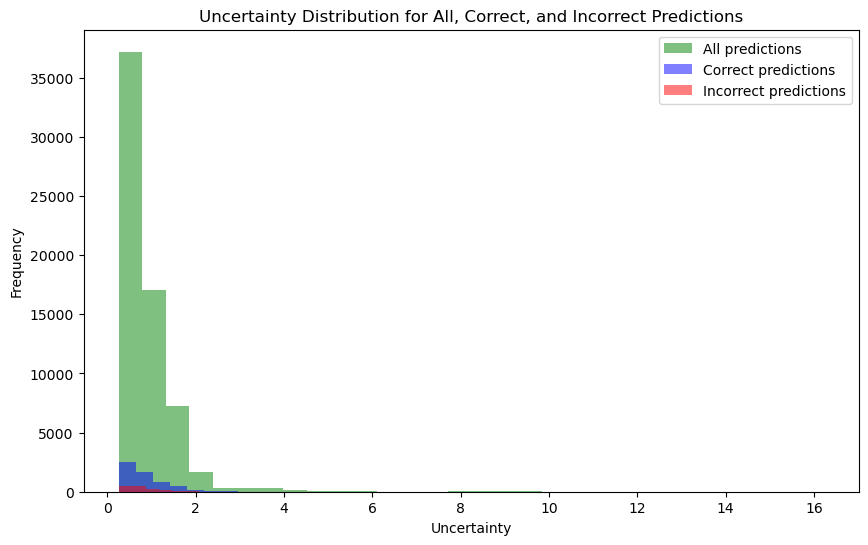

In [11]:
uncertainty = uncertainty.reshape(-1)

correct_indices = np.where(np.argmax(preds, axis=1) == targets)[0]
incorrect_indices = np.where(np.argmax(preds, axis=1) != targets)[0]

correct_uncertainties = uncertainty[correct_indices]
incorrect_uncertainties = uncertainty[incorrect_indices]

plt.figure(figsize=(10, 6))
plt.hist(uncertainty, bins=30, alpha=0.5, label="All predictions", color='green')
plt.hist(correct_uncertainties, bins=30, alpha=0.5, label="Correct predictions", color='blue')
plt.hist(incorrect_uncertainties, bins=30, alpha=0.5, label="Incorrect predictions", color='red')
plt.xlabel("Uncertainty")
plt.ylabel("Frequency")
plt.legend()
plt.title("Uncertainty Distribution for All, Correct, and Incorrect Predictions")
plt.show()
